<a href="https://colab.research.google.com/github/jwang44/Try-colabing-in-colab/blob/main/Patients_new_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECSE 551 Mini-project 1
*Group 10: Junhao Wang, Yinan Zhou, and Ruilin Ji*

This notebook is dedicated for the **Orthopedic patients dataset**, including the model, cross validation, and various experiment. 

## Start here

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/"

/content/drive/My Drive


In [3]:
import numpy as np
import pandas as pd
import scipy.stats
import statistics

## Orthopedic Patients Dataset

In [4]:
# generate new feature by multiplication and normalize
def newfeature(x,y):
  z=x*y
  norz=scipy.stats.zscore(z, axis=0, ddof=0, nan_policy='propagate')
  return norz

In [5]:
# convert csv to dataframe
df = pd.read_csv('orthopedic_patients.csv')
original_data = df.to_numpy()

In [6]:
# normalize feature
NorData = scipy.stats.zscore(df.iloc[:,:-1], axis=0, ddof=0, nan_policy='propagate')
# normalized dataset
NorDataset = np.column_stack((NorData, df['Class']))
# np.savetxt('normalized_orthopedic_patients.csv', NorPatientData, delimiter=',')

New feature

In [7]:
# new feature
NewF1 = newfeature(df.pelvic_incidence, df.sacral_slope) # new feature by multiplying two high-correlation feature
NewF2 = df.iloc[:,0]             # initialize new feature 2 using 1st feature
n_row = np.shape(original_data)[0]
NewF = np.zeros(n_row)            # initialize new features using 0s
for col in range(6):
  # new feature 2: multiplying all features
  if col>0:
    NewF2 = newfeature(NewF2,df.iloc[:,col])
  # new feature 3-8: square all columns
  new = newfeature(df.iloc[:,col],df.iloc[:,col]) # square feature
  NewF = np.column_stack((NewF,new))

NewF = np.delete(NewF,0,1)
# print(NewF2)
# print(np.shape(NewF))
# normalized dataset with new feature
NorDatasetNew = np.column_stack((NorData,NewF1,NewF2,NewF,df['Class']))

## The model

In [8]:
# sigmoid function
def sigmoid(a):
  return 1/(1+np.exp(-a))

class Logistic_regression():
  def __init__(self):#,X_train,y_train,learning_rate,X_test,y_test):
    pass
    
  # train
  def fit(self, X_train, y_train, learning_rate):
    # X_train: training features, y_train: training labels
    n, m = np.shape(X_train)  # n samples, m features
    y_train = y_train.reshape(-1, 1)
    w = np.ones([m+1, 1]) # features + 1
    dummy_feature = np.ones([n, 1])
    X = np.concatenate((X_train, dummy_feature), axis=1) # n samples, m+1 features
    # max iteration allowed
    max_iter = 5000 
    for i in range(max_iter):
      y_predict = sigmoid(np.matmul(X, w))  # n * 1
      grad = -np.matmul(X.T, (y_train - y_predict))  # m+1 * 1
      w = w - learning_rate * grad
      if np.linalg.norm(learning_rate * grad) < 0.001:
        print("Early stop at iteration: ", i+1)
        break
    return w
  
  # validation
  def predict(self,w,X_test):
    #n,m = np.shape(self.X_test)
    n,m = np.shape(X_test)   
    y_predict = np.zeros([n,1])
    for i in range(0,n):
      #xi = self.X_test[i].T
      xi = X_test[i].T
      x0 = np.array([1])
      xi = np.concatenate((xi, x0),axis = 0)
      p1 = sigmoid(np.matmul(w.T,xi)) # calculate probabilities p(y=1|x)
      # covert probabilities to 0 or 1 by thresholding at 0.5
      if p1>=0.5:
        y_predict[i] = 1
      else:
        y_predict[i] = 0
    return y_predict

  # evaluate accuracy
  def Accu_eval(self,y_test,y_predict):
    #y_predict = self.predict(X_test)
    n,j = np.shape(y_predict)
    TP = 0;FP = 0;TN = 0;FN = 0
    # count TP,TN,FP,FN in validation set
    '''for i in range(n):
      if  self.y_test[i]==1 and y_predict[i]==1:
        TP = TP+1
      elif self.y_test[i]==0 and y_predict[i]==0:
        TN = TN+1
      elif self.y_test[i]==0 and y_predict[i]==1:
        FP = FP+1
      elif self.y_test[i]==1 and y_predict[i]==0:
        FN = FN+1'''
    for i in range(n):
      if  y_test[i]==1 and y_predict[i]==1:
        TP = TP+1
      elif y_test[i]==0 and y_predict[i]==0:
        TN = TN+1
      elif y_test[i]==0 and y_predict[i]==1:
        FP = FP+1
      elif y_test[i]==1 and y_predict[i]==0:
        FN = FN+1    
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    # precision = TP/(TP+FP)
    # recall = TP/(TP+FN)
    # F = 2*precision*recall/(precision+recall)
    # specificity = TN/(FP+TN)
    # FPR = FP/(FP+TN)
    print("accuracy:",accuracy)
    # print("precision:",precision)
    # print("recall:",recall)
    # print("F:",F)
    # print("specificity:",specificity)
    # print("False Positive Rate:",FPR)
    print("")
    return accuracy
    

In [9]:
# figure out which feature is of the most importance
model = Logistic_regression()
np.random.shuffle(NorDataset)
X = NorDataset[:, :-1]  # features
y = NorDataset[:, -1]   # labels
w = model.fit(X,y,learning_rate=0.001)
print(w)

Early stop at iteration:  1337
[[ 0.12868317]
 [-0.77648809]
 [ 0.23400975]
 [ 1.20541102]
 [ 1.34390655]
 [-5.68958047]
 [-2.90097301]]


## Cross validation

In [10]:
class Cross_validation():
  def __init__(self, k):
    # k: k-fold
    self.k = k

  def prepare_data(self, data):
    # data: np array converted from csv
    np.random.shuffle(data)
    X = data[:, :-1]  # features
    y = data[:, -1]   # labels

    # split data into k equal segments, assign them to train and test later
    Xs = np.array_split(X, self.k, axis=0)
    ys = np.array_split(y, self.k, axis=0)
    return Xs, ys

  def get_accuracy(self, Xs, ys, lr):
    accu_trains = []
    accu_tests = []
    for i in range(self.k):
      X_cv = Xs[:] # X_cross_validation
      y_cv = ys[:] # y_cross_validation

      X_test = X_cv.pop(i)
      y_test = y_cv.pop(i)

      X_train = np.concatenate(X_cv)
      y_train = np.concatenate(y_cv)

      model = Logistic_regression()
      w = model.fit(X_train, y_train, lr)

      print("----------FOLD ", i+1, "----------")

      print("----Train----")
      y_predict_train = model.predict(w, X_train)
      accu_train = model.Accu_eval(y_train, y_predict_train)
      accu_trains.append(accu_train)

      print("----Validation----")
      y_predict_test = model.predict(w, X_test)
      accu_test = model.Accu_eval(y_test, y_predict_test)
      accu_tests.append(accu_test)

    return np.mean(accu_trains), np.mean(accu_tests)


## Experiment with different learning rates

In [11]:
lrs = np.logspace(-5, -1, 10) # different learning rates to try
cv = Cross_validation(10) # 10-fold cross-validation
Xs, ys = cv.prepare_data(original_data)
for lr in lrs:
  print("---------------LEARNING RATE: ", lr, "---------------")
  accu_train_avg, accu_val_avg = cv.get_accuracy(Xs, ys, lr)
  print("---------------TRAIN AVERAGE ACCURACY", accu_train_avg, "---------------")
  print("---------------VALIDATION AVERAGE ACCURACY", accu_val_avg, "---------------")
  print("\n-------------------------------------------------------------------------------\n")


---------------LEARNING RATE:  1e-05 ---------------
----------FOLD  1 ----------
----Train----
accuracy: 0.7634408602150538

----Validation----
accuracy: 0.7741935483870968

----------FOLD  2 ----------
----Train----
accuracy: 0.7741935483870968

----Validation----
accuracy: 0.7096774193548387

----------FOLD  3 ----------
----Train----
accuracy: 0.7706093189964157

----Validation----
accuracy: 0.8064516129032258

----------FOLD  4 ----------
----Train----
accuracy: 0.7741935483870968

----Validation----
accuracy: 0.7741935483870968

----------FOLD  5 ----------
----Train----
accuracy: 0.7813620071684588

----Validation----
accuracy: 0.7741935483870968

----------FOLD  6 ----------
----Train----
accuracy: 0.7813620071684588

----Validation----
accuracy: 0.8064516129032258

----------FOLD  7 ----------
----Train----
accuracy: 0.7777777777777778

----Validation----
accuracy: 0.8709677419354839

----------FOLD  8 ----------
----Train----
accuracy: 0.7813620071684588

----Validation----
a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


----------FOLD  2 ----------
----Train----
accuracy: 0.7885304659498208

----Validation----
accuracy: 0.8064516129032258

----------FOLD  3 ----------
----Train----
accuracy: 0.7777777777777778

----Validation----
accuracy: 0.8064516129032258

----------FOLD  4 ----------
----Train----
accuracy: 0.7598566308243727

----Validation----
accuracy: 0.7419354838709677

----------FOLD  5 ----------
----Train----
accuracy: 0.7813620071684588

----Validation----
accuracy: 0.7741935483870968

----------FOLD  6 ----------
----Train----
accuracy: 0.7813620071684588

----Validation----
accuracy: 0.8064516129032258

----------FOLD  7 ----------
----Train----
accuracy: 0.7849462365591398

----Validation----
accuracy: 0.7419354838709677

----------FOLD  8 ----------
----Train----
accuracy: 0.7777777777777778

----Validation----
accuracy: 0.7419354838709677

----------FOLD  9 ----------
----Train----
accuracy: 0.7706093189964157

----Validation----
accuracy: 0.6774193548387096

----------FOLD  10 -----

In [12]:
lrs = np.logspace(-5, -1, 10) # different learning rates to try
cv = Cross_validation(10) # 10-fold cross-validation
Xs, ys = cv.prepare_data(NorDataset)
for lr in lrs:
  print("---------------LEARNING RATE: ", lr, "---------------")
  accu_train_avg, accu_val_avg = cv.get_accuracy(Xs, ys, lr)
  print("---------------TRAIN AVERAGE ACCURACY", accu_train_avg, "---------------")
  print("---------------VALIDATION AVERAGE ACCURACY", accu_val_avg, "---------------")
  print("\n-------------------------------------------------------------------------------\n")


---------------LEARNING RATE:  1e-05 ---------------
Early stop at iteration:  1295
----------FOLD  1 ----------
----Train----
accuracy: 0.6129032258064516

----Validation----
accuracy: 0.7096774193548387

Early stop at iteration:  1244
----------FOLD  2 ----------
----Train----
accuracy: 0.6308243727598566

----Validation----
accuracy: 0.4838709677419355

Early stop at iteration:  1234
----------FOLD  3 ----------
----Train----
accuracy: 0.6164874551971327

----Validation----
accuracy: 0.6451612903225806

Early stop at iteration:  1260
----------FOLD  4 ----------
----Train----
accuracy: 0.6487455197132617

----Validation----
accuracy: 0.5483870967741935

Early stop at iteration:  1237
----------FOLD  5 ----------
----Train----
accuracy: 0.6057347670250897

----Validation----
accuracy: 0.6451612903225806

Early stop at iteration:  1265
----------FOLD  6 ----------
----Train----
accuracy: 0.6236559139784946

----Validation----
accuracy: 0.7096774193548387

Early stop at iteration:  128

In [13]:
lrs = np.logspace(-5, -1, 10) # different learning rates to try
cv = Cross_validation(10) # 10-fold cross-validation
Xs, ys = cv.prepare_data(NorDatasetNew)
for lr in lrs:
  print("---------------LEARNING RATE: ", lr, "---------------")
  accu_train_avg, accu_val_avg = cv.get_accuracy(Xs, ys, lr)
  print("---------------TRAIN AVERAGE ACCURACY", accu_train_avg, "---------------")
  print("---------------VALIDATION AVERAGE ACCURACY", accu_val_avg, "---------------")
  print("\n-------------------------------------------------------------------------------\n")


---------------LEARNING RATE:  1e-05 ---------------
Early stop at iteration:  1466
----------FOLD  1 ----------
----Train----
accuracy: 0.6774193548387096

----Validation----
accuracy: 0.7096774193548387

Early stop at iteration:  1459
----------FOLD  2 ----------
----Train----
accuracy: 0.6774193548387096

----Validation----
accuracy: 0.7419354838709677

Early stop at iteration:  1546
----------FOLD  3 ----------
----Train----
accuracy: 0.6810035842293907

----Validation----
accuracy: 0.7096774193548387

Early stop at iteration:  1462
----------FOLD  4 ----------
----Train----
accuracy: 0.6845878136200717

----Validation----
accuracy: 0.7419354838709677

Early stop at iteration:  1495
----------FOLD  5 ----------
----Train----
accuracy: 0.6810035842293907

----Validation----
accuracy: 0.5161290322580645

Early stop at iteration:  1441
----------FOLD  6 ----------
----Train----
accuracy: 0.6845878136200717

----Validation----
accuracy: 0.6774193548387096

Early stop at iteration:  148

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


----------FOLD  1 ----------
----Train----
accuracy: 0.8387096774193549

----Validation----
accuracy: 0.7741935483870968

----------FOLD  2 ----------
----Train----
accuracy: 0.8351254480286738

----Validation----
accuracy: 0.7419354838709677

----------FOLD  3 ----------
----Train----
accuracy: 0.8315412186379928

----Validation----
accuracy: 0.8709677419354839

----------FOLD  4 ----------
----Train----
accuracy: 0.8028673835125448

----Validation----
accuracy: 0.8387096774193549

----------FOLD  5 ----------
----Train----
accuracy: 0.8530465949820788

----Validation----
accuracy: 0.8709677419354839

----------FOLD  6 ----------
----Train----
accuracy: 0.8279569892473119

----Validation----
accuracy: 0.8064516129032258

----------FOLD  7 ----------
----Train----
accuracy: 0.8387096774193549

----Validation----
accuracy: 0.8064516129032258

----------FOLD  8 ----------
----Train----
accuracy: 0.8100358422939068

----Validation----
accuracy: 0.8387096774193549

----------FOLD  9 ------

## Experiment with different features

During the experiment on different learning rates, we found that the best learning rates for the three sets of features: 

* Original dataset: **0.0017**

* Normalized dataset: **0.000077**

* Normalized dataset with new features: **0.000077**

For displaying the model accuracies more clearly, in this section
we train a model on each dataset using its best learning rate. 

In [14]:
lr = 0.0017
cv = Cross_validation(10) # 10-fold cross-validation
Xs, ys = cv.prepare_data(original_data)
print("----------Using normalized features, with new features----------")
accu_avg_train, accu_avg_val = cv.get_accuracy(Xs, ys, lr)
print("----------AVERAGE ACCURACY", accu_avg_val, "----------")
print("\n---------------------------------------------------------------------")


----------Using normalized features, with new features----------
----------FOLD  1 ----------
----Train----
accuracy: 0.7562724014336918

----Validation----
accuracy: 0.8064516129032258



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


----------FOLD  2 ----------
----Train----
accuracy: 0.7562724014336918

----Validation----
accuracy: 0.7741935483870968

----------FOLD  3 ----------
----Train----
accuracy: 0.7813620071684588

----Validation----
accuracy: 0.7419354838709677

----------FOLD  4 ----------
----Train----
accuracy: 0.7562724014336918

----Validation----
accuracy: 0.6774193548387096

----------FOLD  5 ----------
----Train----
accuracy: 0.7741935483870968

----Validation----
accuracy: 0.7096774193548387

----------FOLD  6 ----------
----Train----
accuracy: 0.7562724014336918

----Validation----
accuracy: 0.8387096774193549

----------FOLD  7 ----------
----Train----
accuracy: 0.8136200716845878

----Validation----
accuracy: 0.7419354838709677

----------FOLD  8 ----------
----Train----
accuracy: 0.7921146953405018

----Validation----
accuracy: 0.7096774193548387

----------FOLD  9 ----------
----Train----
accuracy: 0.7598566308243727

----Validation----
accuracy: 0.7741935483870968

----------FOLD  10 -----

In [15]:
lr = 0.000077
cv = Cross_validation(10) # 10-fold cross-validation
Xs, ys = cv.prepare_data(NorDataset)
print("----------Using normalized features, without new features----------")
accu_avg_train, accu_avg_val = cv.get_accuracy(Xs, ys, lr)
print("----------AVERAGE ACCURACY", accu_avg_val, "----------")
print("\n---------------------------------------------------------------------")


----------Using normalized features, without new features----------
Early stop at iteration:  1258
----------FOLD  1 ----------
----Train----
accuracy: 0.8637992831541219

----Validation----
accuracy: 0.8709677419354839

Early stop at iteration:  1312
----------FOLD  2 ----------
----Train----
accuracy: 0.8494623655913979

----Validation----
accuracy: 0.9032258064516129

Early stop at iteration:  1326
----------FOLD  3 ----------
----Train----
accuracy: 0.8709677419354839

----Validation----
accuracy: 0.8709677419354839

Early stop at iteration:  1318
----------FOLD  4 ----------
----Train----
accuracy: 0.8709677419354839

----Validation----
accuracy: 0.8709677419354839

Early stop at iteration:  1208
----------FOLD  5 ----------
----Train----
accuracy: 0.8745519713261649

----Validation----
accuracy: 0.7096774193548387

Early stop at iteration:  1349
----------FOLD  6 ----------
----Train----
accuracy: 0.8566308243727598

----Validation----
accuracy: 0.9032258064516129

Early stop at 

In [17]:
lr = 0.00007
cv = Cross_validation(10) # 10-fold cross-validation
Xs, ys = cv.prepare_data(NorDatasetNew)
print("----------Using normalized features, with new features----------")
accu_avg_train, accu_avg_val = cv.get_accuracy(Xs, ys, lr)
print("----------AVERAGE ACCURACY: train-", accu_avg_train," vs. validation-",accu_avg_val, "----------")
print("\n---------------------------------------------------------------------")


----------Using normalized features, with new features----------
Early stop at iteration:  1108
----------FOLD  1 ----------
----Train----
accuracy: 0.8673835125448028

----Validation----
accuracy: 0.8064516129032258

Early stop at iteration:  1258
----------FOLD  2 ----------
----Train----
accuracy: 0.8673835125448028

----Validation----
accuracy: 0.9354838709677419

Early stop at iteration:  1129
----------FOLD  3 ----------
----Train----
accuracy: 0.8602150537634409

----Validation----
accuracy: 0.8709677419354839

Early stop at iteration:  1232
----------FOLD  4 ----------
----Train----
accuracy: 0.8745519713261649

----Validation----
accuracy: 0.8064516129032258

Early stop at iteration:  1200
----------FOLD  5 ----------
----Train----
accuracy: 0.8673835125448028

----Validation----
accuracy: 0.8709677419354839

Early stop at iteration:  1144
----------FOLD  6 ----------
----Train----
accuracy: 0.8637992831541219

----Validation----
accuracy: 0.9354838709677419

Early stop at ite

## Measure the run time
See whether the model converges faster on normalized data than on original data. This is measured by training the model and time it. This part stands on its own, and is not related to any of the above process

###Using the original dataset

In [18]:
model = Logistic_regression()
np.random.shuffle(original_data)
X = original_data[:, :-1]  # features
y = original_data[:, -1]   # labels

In [19]:
%%timeit
w = model.fit(X, y, learning_rate=0.00001)

1 loop, best of 3: 143 ms per loop


In [20]:
%%timeit
w = model.fit(X, y, learning_rate=0.001)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


1 loop, best of 3: 219 ms per loop


In [21]:
%%timeit
w = model.fit(X, y, learning_rate=0.01)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


1 loop, best of 3: 170 ms per loop


###Using normalized dataset

In [22]:
model = Logistic_regression()
np.random.shuffle(NorDataset)
X = NorDataset[:, :-1]  # features
y = NorDataset[:, -1]   # labels

In [23]:
%%timeit
w = model.fit(X, y, learning_rate=0.00001)

Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early stop at iteration:  1216
Early st

In [24]:
%%timeit
w = model.fit(X, y, learning_rate=0.001)

Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early stop at iteration:  1337
Early st

In [25]:
%%timeit
w = model.fit(X, y, learning_rate=0.01)

Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop at iteration:  344
Early stop

###Scan through more lrs

learning rate:  0.0001
Early stop at iteration:  1603
time:  0.10298991203308105
learning rate:  0.0001438449888287663
Early stop at iteration:  1778
time:  0.10708999633789062
learning rate:  0.00020691380811147902
Early stop at iteration:  1850
time:  0.11705923080444336
learning rate:  0.00029763514416313193
Early stop at iteration:  1832
time:  0.10786056518554688
learning rate:  0.00042813323987193956
Early stop at iteration:  1738
time:  0.10098552703857422
learning rate:  0.0006158482110660267
Early stop at iteration:  1588
time:  0.09635329246520996
learning rate:  0.0008858667904100823
Early stop at iteration:  1403
time:  0.08380007743835449
learning rate:  0.0012742749857031334
Early stop at iteration:  1203
time:  0.07233262062072754
learning rate:  0.0018329807108324356
Early stop at iteration:  1006
time:  0.05965924263000488
learning rate:  0.0026366508987303583
Early stop at iteration:  823
time:  0.04789304733276367
learning rate:  0.00379269019073225
Early stop at ite

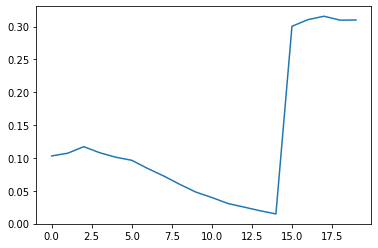

In [26]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.shuffle(NorDataset)
X = NorDataset[:, :-1]  # features
y = NorDataset[:, -1]   # labels

lrs = np.logspace(-4, -1, 20) # different learning rates to try
times = []

for lr in lrs:
  model = Logistic_regression()
  print("learning rate: ", lr)
  t1 = time.time()
  w = model.fit(X, y, learning_rate=lr)
  t2 = time.time()
  print("time: ", t2-t1)
  times.append(t2-t1)

plt.plot(times)